<a href="https://colab.research.google.com/github/ccaballeroh/InferenciaCausal_A22/blob/main/code/solutions/Causal_Inference_A22_Ex01_Solution.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

En esta celda escribe tu **nombre** y tu **programa** (ESCOM, MCC, MCIC o DCC)

# Análisis de salarios entre hombres y mujeres

Supongamos que trabajamos como _data scientists_ en una empresa y se nos proporciona un conjunto de datos sobre los salarios entre hombres y mujeres en la compañía.

Con este conjunto de datos se nos pide contestar **¿cuál es la brecha de paga entre hombres y mujeres en la empresa?**

## Preliminares

Importa los módulos/paquetes necesarios.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.formula.api as smf
from tqdm import tqdm

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


Definición de funciones auxiliares usadas.

In [2]:
def generate_data(**kwargs):
  seed, N = kwargs["seed"], kwargs["N"]
  np.random.seed(kwargs["seed"])
  sex = np.random.binomial(n=1, p=0.5, size=N)  # 0=Female, 1=Male
  position = ( (sex*np.random.binomial(n=1, p=0.4, size=N) +
              (1-sex)*np.random.binomial(n=1, p=0.1, size=N)) > 0 ).astype(int) 
  salary = (1-sex)*np.random.normal(1000, 500, size=N) +\
          position*np.random.normal(15_000, 3_000, size=N) +\
          np.random.normal(30_000, 5_000, size=N)
  data = pd.DataFrame({
      "sexo":sex,
      "puesto":position,
      "salario":salary
  })
  data.sexo = np.where(data.sexo > 0, "Hombre", "Mujer")
  data.puesto = np.where(data.puesto > 0, "Gerencial", "No gerencial")
  return data

def read_data(**kwargs):
  csv_filename = kwargs["csv_filename"]
  return pd.read_csv(csv_filename, index_col=0)

La variable `ENV` debe tener valor `"HW"` cuando está en modo de tarea.

In [3]:
ENV = "HW"

In [4]:
get_data = read_data if ENV == "HW" else generate_data

## Inicio

Lee los datos desde el archivo `ex_01_wages.csv` con la función `read_data` definida arriba.

In [5]:
kwargs = {
    "csv_filename": "https://raw.githubusercontent.com/ccaballeroh/InferenciaCausal_A22/main/data/ex_01_wages.csv"
}

data = get_data(**kwargs)

if not ENV == "HW":
  data.to_csv("ex_01_wages.csv")

## Análisis exploratorio de datos

Veamos las primeras líneas del conjunto de datos guardado en el DataFrame llamado `data`.

In [6]:
# Llama el método `head()` del DataFrame
data.head()

,sexo,puesto,salario
index,,,
0,Hombre,No gerencial,24092.767040
1,Mujer,No gerencial,25574.011864
2,Hombre,Gerencial,39051.930008
3,Mujer,No gerencial,26058.226921
4,Hombre,Gerencial,44688.832593


Imprime el tipo de dato de las columnas de `data`.

In [7]:
# Llama el atributo `dtypes` del DataFrame
data.dtypes

sexo        object
puesto      object
salario    float64
dtype: object

Imprime el resumen del conjunto de datos.

In [8]:
# Llama al método `describe()` con el argumento `include=['object', 'float', 'int]`
data.describe(include=['object', 'float', 'int'])

,sexo,puesto,salario
count,200,200,200.000000
unique,2,2,NaN
top,Mujer,No gerencial,NaN
freq,105,146,NaN
mean,NaN,NaN,35155.418105
std,NaN,NaN,8506.795221
min,NaN,NaN,17037.452191
25%,NaN,NaN,28699.515533
50%,NaN,NaN,33567.270374
75%,NaN,NaN,40003.413391


Haz una gráfica de caja de `salario` por `sexo`.

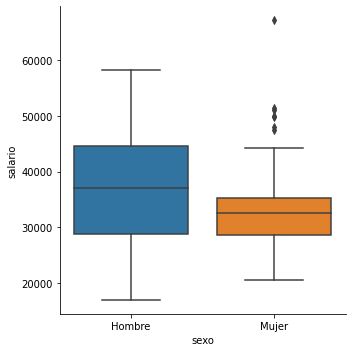

In [9]:
# Utiliza `catplot` de Seaborn
sns.catplot(x="sexo", y="salario", kind="box", data=data)

¿Qué opinas sobre si hay o no diferencia salarial entre hombres y mujeres?

**Tu respuesta:**

Ahora, haz una gráfica de caja de `salario` por `sexo` separando por la tercera variable `puesto`.

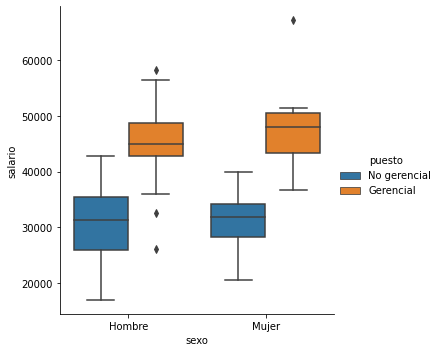

In [10]:
# Utiliza `catplot`
sns.catplot(x="sexo", y="salario", hue="puesto", kind="box", data=data)

¿Cambió tu opinión? ¿Hay diferencia entre hombres y mujeres comparando por el mismo tipo de puesto?

**Tu respuesta:**

Ahora, haz una gráfica categórica de tipo `swarm` usando `catplot` de Seaborn. En el eje de las equis coloca el `puesto`; en el de las ye, `salario` y separa por `sexo`. 

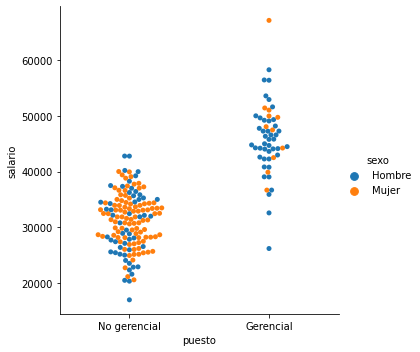

In [11]:
# Tu código
sns.catplot(x="puesto", y="salario", hue="sexo", kind="swarm", data=data)

¿Es mucha la diferencia en salario entre gerentes y no gerentes?

**Tu respuesta:**

Ahora haz la misma gráfica, pero invierte las variables para las equis y el _hue_.

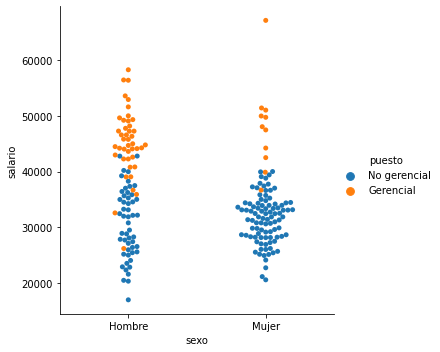

In [12]:
# Tu código
sns.catplot(x="sexo", y="salario", hue="puesto", kind="swarm", data=data)

¿Hay más o menos mujeres que hombres en puestos altos? ¿Y en puestos bajos?

Genera una tabla de contingencia para el salario promedio y otra para el número total de personas en cada combinación de categorías.

In [13]:
# Utiliza `crosstab` de Pandas con la función de agregación `mean` de Numpy
pd.crosstab(data.puesto, data.sexo, data.salario, aggfunc=np.mean)

sexo,Hombre,Mujer
puesto,,
Gerencial,45342.802726,48006.103590
No gerencial,30692.538241,31460.255062


In [14]:
# Utiliza `crosstab` de Pandas. Pasa `True` al parámetro `margins`
pd.crosstab(data.puesto, data.sexo, margins=True)

sexo,Hombre,Mujer,All
puesto,,,
Gerencial,43,11,54
No gerencial,52,94,146
All,95,105,200


## Pregunta de análisis

Para este conjunto de datos, se nos pide determinar la brecha salarial entre hombres y mujeres en la empresa en la que se recolectaron estos datos.

- Antes de continuar, usa las tablas de contingencia anteriores para intentar contestar la pregunta.

**Tu respuesta:**

## Análisis guiado

## 1. Calcula el salario promedio de mujeres y hombres

- Calcula el salario promedio de las mujeres
- Calcula el salario promedio de los hombres
- Saca la diferencia

¿Quién gana más?

In [15]:
## tu código

promedio_mujeres = np.mean(data.loc[data.sexo=="Mujer", "salario"])
promedio_hombres = np.mean(data.loc[data.sexo=="Hombre", "salario"])

##

print(f"""
Las mujeres ganan en promedio: ${promedio_mujeres:,.2f}
Los hombres ganan en promedio: ${promedio_hombres:,.2f}

La diferencia es ${promedio_mujeres - promedio_hombres:,.2f}
""")


Las mujeres ganan en promedio: $33,193.63
Los hombres ganan en promedio: $37,323.71

La diferencia es $-4,130.08



## 2. Ahora compara por estratos

- Compara por categoría `puesto` de forma separada.

- ¿Ahora, cuál es la diferencia salarial en cada categoría?

- ¿Quién gana más en cada tipo de puesto?

In [16]:
data.head()

,sexo,puesto,salario
index,,,
0,Hombre,No gerencial,24092.767040
1,Mujer,No gerencial,25574.011864
2,Hombre,Gerencial,39051.930008
3,Mujer,No gerencial,26058.226921
4,Hombre,Gerencial,44688.832593


In [17]:
## Tu código
## Utiliza `groupby` para sacar el promedio salarial por puesto y sexo
## también cuenta la ocurrencia de cada combinación de categorías (i.e., 
## Gerencia y Hombre, Gerencial y Mujer, etc.)


data_grpd = (data
             .groupby(["puesto", "sexo"])
             .agg({"salario":"mean", "sexo":"count"})
             .rename(columns={"sexo":"cuentas"}) #renombra la columna `sexo` a cuentas
             ) 
##

data_grpd

salario  cuentas
puesto       sexo                         
Gerencial    Hombre  45342.802726       43
             Mujer   48006.103590       11
No gerencial Hombre  30692.538241       52
             Mujer   31460.255062       94

In [18]:
promedio_mujeres_gerentes = data_grpd.loc[
                                          [("Gerencial", "Mujer")],
                                          "salario"
                                          ].values
promedio_hombres_gerentes = data_grpd.loc[
                                          [("Gerencial", "Hombre")],
                                          "salario"
                                          ].values
diferencia_gerentes = (promedio_mujeres_gerentes - promedio_hombres_gerentes)[0]

print(f"""
Las mujeres gerentes ganan en promedio: ${promedio_mujeres_gerentes[0]:,.2f}
Los hombres gerentes ganan en promedio: ${promedio_hombres_gerentes[0]:,.2f}

La diferencia es ${diferencia_gerentes:,.2f}
""")


Las mujeres gerentes ganan en promedio: $48,006.10
Los hombres gerentes ganan en promedio: $45,342.80

La diferencia es $2,663.30



In [19]:
promedio_mujeres_no_gerentes = data_grpd.loc[
                                             [("No gerencial", "Mujer")],
                                             "salario"].values
promedio_hombres_no_gerentes = data_grpd.loc[
                                             [("No gerencial", "Hombre")],
                                             "salario"
                                             ].values
diferencia_no_gerentes = (promedio_mujeres_no_gerentes -
                          promedio_hombres_no_gerentes)[0]

print(f"""
Las mujeres no gerentes ganan en promedio: ${promedio_mujeres_no_gerentes[0]:,.2f}
Los hombres no gerentes ganan en promedio: ${promedio_hombres_no_gerentes[0]:,.2f}

La diferencia es ${diferencia_no_gerentes:,.2f}
""")


Las mujeres no gerentes ganan en promedio: $31,460.26
Los hombres no gerentes ganan en promedio: $30,692.54

La diferencia es $767.72



## Opcional

Haz una suma ponderada por la cantidad de gerentes de las diferencias anteriores.

In [20]:
## Tu código
diferencia_ponderada = (
    len(data.loc[data.puesto=="Gerencial"])*(diferencia_gerentes) +
    len(data.loc[data.puesto=="No gerencial"])*(diferencia_no_gerentes)
    )/len(data)
##

print(f"La diferencia ponderada es: ${diferencia_ponderada:,.2f}")

La diferencia ponderada es: $1,279.52


## Reflexión

- ¿Qué crees que sea lo que esté sucediendo? ¿Cómo es posible que al ver cada tipo de puesto la diferencia favorezca a un sexo, pero al ver la población entera la preferencia se invierte?
- Si las etiquetas de los datos fueran `estilo de vida` en lugar de `sexo`, `puesto` y `salario`, ¿cambiaría tu respuesta?

**Tu respuesta:**

# Análisis estadístico de diferencias de medias

Haz una regresión lineal `salario ~ sexo`.

Compara el coeficiente (pendiente) de la variable categórica `sexo` con el resultado que habías obtenido arriba.

¿Las diferencias son (estadísticamente) significativas?

**Tu respuesta:**

In [21]:
uncontrolled_model = smf.ols("salario ~ sexo", data=data).fit()
uncontrolled_model.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                    Results: Ordinary least squares
=======================================================================
Model:                OLS               Adj. R-squared:      0.054     
Dependent Variable:   salario           AIC:                 4177.8424 
Date:                 2022-02-18 00:06  BIC:                 4184.4391 
No. Observations:     200               Log-Likelihood:      -2086.9   
Df Model:             1                 F-statistic:         12.43     
Df Residuals:         198               Prob (F-statistic):  0.000524  
R-squared:            0.059             Scale:               6.8434e+07
-----------------------------------------------------------------------
                Coef.     Std.Err.    t    P>|t|    [0.025     0.975]  
-----------------------------------------------------------------------
Intercept     37323.7106  848.7412 43.9754 0.0000 35649.9782 38997.4430
sexo[T.Mujer] -4130.0809 1171.3741 -3.5258 0.0005 -6440.0511 -1820.1107
-----------------------------------------------------------------------
Omnibus:                13.506         Durbin-Watson:            2.108 
Prob(Omnibus):          0.001          Jarque-Bera (JB):         15.725
Skew:                   0.520          Prob(JB):                 0.000 
Kurtosis:               3.896          Condition No.:            3     
=======================================================================

"""

Haz una regresión lineal `salario ~ sexo + puesto`.

Ahora, compara el coeficiente (pendiente) de la variable categórica `sexo` con el resultado _ponderado_ que habías obtenido arriba (tal vez no sea exactamente el mismo).

¿Las diferencias son (estadísticamente) significativas?

**Tu respuesta:**

In [22]:
controlled_model = smf.ols("salario ~ sexo + puesto", data=data).fit()
controlled_model.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                          Results: Ordinary least squares
===================================================================================
Model:                    OLS                   Adj. R-squared:          0.591     
Dependent Variable:       salario               AIC:                     4011.0757 
Date:                     2022-02-18 00:06      BIC:                     4020.9707 
No. Observations:         200                   Log-Likelihood:          -2002.5   
Df Model:                 2                     F-statistic:             144.9     
Df Residuals:             197                   Prob (F-statistic):      1.98e-39  
R-squared:                0.595                 Scale:                   2.9580e+07
-----------------------------------------------------------------------------------
                          Coef.    Std.Err.    t     P>|t|     [0.025      0.975]  
-----------------------------------------------------------------------------------
Intercept               45648.8649 759.5002  60.1038 0.0000  44151.0704  47146.6594
sexo[T.Mujer]            1160.8139 836.8451   1.3871 0.1670   -489.5108   2811.1385
puesto[T.No gerencial] -15209.4165 941.3004 -16.1579 0.0000 -17065.7352 -13353.0978
-----------------------------------------------------------------------------------
Omnibus:                    5.588              Durbin-Watson:                 1.809
Prob(Omnibus):              0.061              Jarque-Bera (JB):              8.377
Skew:                       0.001              Prob(JB):                      0.015
Kurtosis:                   4.003              Condition No.:                 4    
===================================================================================

"""

# Análisis con _Bootstrap_

Analiza el siguiente código para contestar las siguientes preguntas:

- ¿Qué regresa la función `estimate_statistic`?
- ¿Qué hace la línea 10 del código de la siguiente celda?
- Compara el valor de la variable `mean_difference` con los resultados obtenidos en las secciones anteriores.
- ¿Cómo se interpreta el intervalo $[\mathrm{LL}, \mathrm{UU}]$?
- ¿Cuántos elementos tiene el arreglo `bootstrap_statistcs` y por qué su histograma tiende a una distribución normal?



**Tu respuesta:**

In [23]:
def estimate_statistic(bootstrap_sample):
  return smf.ols("salario ~ sexo", data=bootstrap_sample).fit().params[1]


N_bootstraps = 10_000
bootstrap_statistics = []


for _ in tqdm(range(N_bootstraps)):
  bootstrap_sample = data.sample(n=len(data), replace=True)
  statistic = estimate_statistic(bootstrap_sample)
  bootstrap_statistics.append(statistic)

bootstrap_statistics = np.array(bootstrap_statistics)
mean_difference = np.mean(bootstrap_statistics)
LL, UU = np.quantile(bootstrap_statistics, 0.025), np.quantile(bootstrap_statistics, 0.975)

100%|██████████| 10000/10000 [01:25<00:00, 116.68it/s]


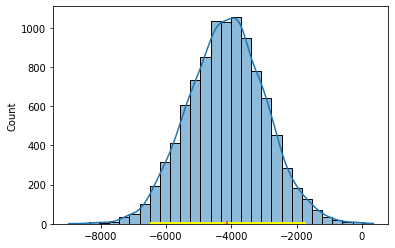

In [24]:
plt.plot([LL, UU], [0, 0], color="yellow", lw=5)
plt.plot([mean_difference, mean_difference], [0, 10], color="red")
sns.histplot(data=bootstrap_statistics, bins=30, kde=True)

In [25]:
print(f"""
El valor estimado por remuestreo con reemplazo es ${mean_difference:,.2f}.
Con un intervalo de confianza de bootstrap de [${LL:,.2f}, {UU:,.2f}] al 95 %.
""")


El valor estimado por remuestreo con reemplazo es $-4,136.90.
Con un intervalo de confianza de bootstrap de [$-6,418.93, -1,795.90] al 95 %.

